# Comparação de dados - [covid.saude.gov.br](https://covid.saude.gov.br/) e [brasil.io](https://brasil.io/dataset/covid19)

O Ministério da Saúde retirou, no dia 05/06/2020, os dados do portal [covid.saude.gov.br](https://covid.saude.gov.br/) e retomou a disponibilização no dia 10/06/2020

Alternativamente, o site [brasil.io](https://brasil.io/dataset/covid19) tem mantido um conjunto de dados disponibilidades pelas Secretarias de Saúde estaduais


In [1]:
from datetime import date
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from ipywidgets import interact

%matplotlib inline
sns.set_style('whitegrid')

pd.set_option('display.max_rows', 150)
# pd.set_option('plotting.backend', 'matplotlib')
pd.options.plotting.backend = "plotly"
pd.options.plotting.backend = "matplotlib"

In [2]:
print("Última atualização do notebook: {}".format(date.today().strftime('%m/%d/%y')))

Última atualização do notebook: 06/18/20


# Dados [covid.saude.gov.br](https://covid.saude.gov.br)

## Dados dos dias 06/02/2020 e 06/17/2020

In [3]:
dados_0602 = pd.read_excel('HIST_PAINEL_COVIDBR_02jun2020.xlsx')

In [4]:
dados_novos = pd.read_excel('HIST_PAINEL_COVIDBR_17jun2020.xlsx')

## Funções de tratamento de colunas e criação de novos dataframes específicos para estados, municípios e regiões

In [5]:
def contador_dias(dataframe, groupby_list):
    dataframe['contadorDiasCasos'] = dataframe.sort_values(by=['datetime']).groupby(groupby_list)['casosAcumulado'].cumcount() + 1
    dataframe['contadorObitosCasos'] = dataframe[dataframe['obitosAcumulado'] > 0].sort_values(by=['datetime']).groupby(groupby_list)['obitosAcumulado'].cumcount() + 1
    dataframe['contadorObitosCasos'].fillna(0, inplace=True)
    dataframe['contadorObitosCasos'] = dataframe['contadorObitosCasos'].astype(int)

# contador_dias(dados_estados, ['estado'])
# contador_dias(dados_regiao, ['regiao'])
# contador_dias(dados_municipios, ['municipioEstado'])

In [6]:
def column_treatment(df):
    df['datetime'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df[['coduf','codmun','codRegiaoSaude']] = df[['coduf', 'codmun', 'codRegiaoSaude']].astype('category')
    df.dropna(subset=['populacaoTCU2019'], inplace=True)
    if df['populacaoTCU2019'].dtype == 'O':
        df['populacaoTCU2019'] = df['populacaoTCU2019'].apply(lambda i: re.sub(r"\(..?\)", "", i) if r"(" in i else i)
        df['populacaoTCU2019'] = df['populacaoTCU2019'].str.replace('.','')
        df['populacaoTCU2019'] = df['populacaoTCU2019'].astype('int')
    df[['Recuperadosnovos', 'emAcompanhamentoNovos']] = df[['Recuperadosnovos', 'emAcompanhamentoNovos']].fillna(0)
    df[['Recuperadosnovos', 'emAcompanhamentoNovos']] = df[['Recuperadosnovos', 'emAcompanhamentoNovos']].astype('int')
    df['casosNormalizado_100mil_habit'] = df['casosAcumulado'] / (df['populacaoTCU2019'] / 100000)
    df['obitosNormalizado_100mil_habit'] = df['obitosAcumulado'] / (df['populacaoTCU2019'] / 100000)
    df['casosNormalizado_1milhao_habit'] = df['casosAcumulado'] / (df['populacaoTCU2019'] / 1000000)
    df['obitosNormalizado_1milhao_habit'] = df['obitosAcumulado'] / (df['populacaoTCU2019'] / 1000000)
    df['tipoTerritorio'] = np.where(df['municipio'].notna(), "municipio", 
                                                  (np.where(
                                                      (df['estado'].notna()) & (df['regiao']!='Brasil'), 
                                                      "estado", "pais")))
    df['municipioEstado'] = np.where(df['municipio'].notna(), df['municipio']+'-'+df['estado'], np.nan)
    
    df_pais = df[df['tipoTerritorio'] == 'pais'].copy()
    df_estado = df[df['tipoTerritorio'] == 'estado'].copy()
    df_municipio = df[df['tipoTerritorio'] == 'municipio'].copy()
    contador_dias(df_pais, ['regiao'])
    contador_dias(df_estado, ['estado'])
    contador_dias(df_municipio, ['municipioEstado'])
    df = pd.concat([df_pais, df_estado, df_municipio], ignore_index=True)
    
    df.drop(['data'], axis=1, inplace=True)
    df = df[['regiao', 'estado', 'municipio', 'municipioEstado', 'tipoTerritorio', 'datetime',
             'coduf', 'codmun', 'codRegiaoSaude', 'nomeRegiaoSaude', 'semanaEpi', 'populacaoTCU2019',
             'casosAcumulado', 'obitosAcumulado', 'casosNovos', 'obitosNovos', 'contadorDiasCasos', 'contadorObitosCasos', 
             'casosNormalizado_100mil_habit', 'obitosNormalizado_100mil_habit', 'casosNormalizado_1milhao_habit', 'obitosNormalizado_1milhao_habit',
             'Recuperadosnovos', 'emAcompanhamentoNovos']]
    
    return df

In [7]:
# def rolling_average():
#     dados_municipios['rolling_avg_7d_casosAcumulado'] = dados_municipios.sort_values(by=['datetime'])\
#                                                                     .groupby(['municipioEstado'])\
#                                                                     .rolling(7)['casosAcumulado']\
#                                                                     .mean().reset_index(0,drop=True)

#     dados_municipios['rolling_avg_7d_casosNormalizado'] = dados_municipios.sort_values(by=['datetime'])\
#                                                                     .groupby(['municipioEstado'])\
#                                                                     .rolling(7)['casosNormalizado']\
#                                                                     .mean().reset_index(0,drop=True)

# dados_municipios.sort_values(by=['datetime']).groupby(['municipioEstado']).rolling(7)['casosAcumulado'].mean()
# dados_municipios.sort_values(by=['datetime']).groupby(['municipioEstado']).rolling(7)['casosAcumulado'].mean().reset_index(0,drop=True)

## Funções de plot

In [8]:
def caracteristicas_plot(bbox_anchor_x, bbox_anchor_y, labels_fontsize, legend_bool,
                        xaxis_datetime_bool, xaxis_title_string, yaxis_title_string):
    '''
    Função com os ajustes de características do plot, i.e tamanho das fontes de títulos e labels
    '''
    
    # Posiciona caixa de legendas para fora do gráfico, ao lado direito, se o usuário escolher ter legenda
    if legend_bool == True:
        plt.gcf().legend(bbox_to_anchor=(bbox_anchor_x, bbox_anchor_y), prop={'size': labels_fontsize-2})

    # Formata ticks do eixo x como datas, se o usuário escolher usar datas no eixo x
    if xaxis_datetime_bool == True:
        # formato da data do eixo para dia-mês e localização dos ticks no eixo
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m')) # '%d-%m' dia-mês; %U or %W Week number of the year
        plt.gca().xaxis.set_major_locator(mdates.DayLocator()) #mdates.DayLocator(); mdates.MonthLocator() determina a posição do tick quando se plota datas
        
        # rotaciona as labels do eixo x
        plt.gcf().autofmt_xdate()
              
    # nome do título do eixo
    plt.gca().set_xlabel(xaxis_title_string)
    plt.gca().set_ylabel(yaxis_title_string)
    
    # formata número (i.e. 10^4 para 10000 - %d=integer)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d'))

    # tamanho da fonte das labels/títulos do eixo
    plt.gca().title.set_fontsize(labels_fontsize) 
    plt.gca().xaxis.label.set_fontsize(labels_fontsize) 
    plt.gca().yaxis.label.set_fontsize(labels_fontsize)

    # tamanho da fonte dos 'ticks' (dados/números/datas) do eixo
    # list comprehension para cada item/dados/número/dado do eixo
    [tick.label.set_fontsize(labels_fontsize) for tick in plt.gca().xaxis.get_major_ticks()]
    [tick.label.set_fontsize(labels_fontsize) for tick in plt.gca().yaxis.get_major_ticks()]
    
    plt.tight_layout()

In [9]:
# fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
def plot_data_completo(dataframe, column_string, rows_list, groupby_list, column_list, 
                       title_string, legend_bool, logy_bool, figsize_x, figsize_y, 
                       bbox_anchor_x, bbox_anchor_y, labels_fontsize,
                       xaxis_datetime_bool, xaxis_title_string, yaxis_title_string, axes):
    dataframe.loc[dataframe[column_string].isin(rows_list)]\
        .groupby(groupby_list)[column_list]\
        .sum()\
        .unstack()\
        .plot(figsize=(figsize_x, figsize_y), legend=False, logy=logy_bool, title=title_string, ax=axes)
    
    caracteristicas_plot(bbox_anchor_x, bbox_anchor_y, labels_fontsize, legend_bool,
                        xaxis_datetime_bool, xaxis_title_string, yaxis_title_string)

## Análise dos dados

In [10]:
municipios_plot = ['Rio de Janeiro-RJ']
groupby_var = ['contadorDiasCasos', 'municipioEstado']
xaxis_datetime_bool = False

# fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# plot_data_completo(dataframe = dados_municipios0602, column_string = 'municipioEstado', 
#             rows_list = municipios_plot, 
#             groupby_list = groupby_var,
#             column_list = ['casosNormalizado'], 
#             title_string = "Casos - Municípios", 
#             legend_bool = True, logy_bool = True, figsize_x = 15, figsize_y = 10, 
#             bbox_anchor_x = 1.1, bbox_anchor_y = 0.5, labels_fontsize = 18,
#             xaxis_datetime_bool = xaxis_datetime_bool, xaxis_title_string = '', yaxis_title_string = '', axes=axes)

# plot_data_completo(dataframe = dados_municipios_novos, column_string = 'municipioEstado', 
#             rows_list = municipios_plot, 
#             groupby_list = groupby_var,
#             column_list = ['casosNormalizado'], 
#             title_string = "Casos - Municípios", 
#             legend_bool = True, logy_bool = True, figsize_x = 15, figsize_y = 10, 
#             bbox_anchor_x = 1.1, bbox_anchor_y = 0.5, labels_fontsize = 18,
#             xaxis_datetime_bool = xaxis_datetime_bool, xaxis_title_string = '', yaxis_title_string = '', axes=axes)

In [11]:
# estados_plot = ['RJ','SP','MG','ES']
# groupby_var = ['datetime', 'estado']
# xaxis_datetime_bool = True

# fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# plot_data_completo(dataframe = dados_estados, column_string = 'estado', 
#             rows_list = estados_plot, 
#             groupby_list = groupby_var,
#             column_list = ['casosNormalizado'], 
#             title_string = "Casos - Municípios", 
#             legend_bool = True, logy_bool = True, figsize_x = 15, figsize_y = 10, 
#             bbox_anchor_x = 1.1, bbox_anchor_y = 0.5, labels_fontsize = 18,
#             xaxis_datetime_bool = xaxis_datetime_bool, xaxis_title_string = '', yaxis_title_string = '', axes=axes)

### Comparativo dados [covid.saude.gov.br](https://covid.saude.gov.br)

In [12]:
dados_tratados_0602 = column_treatment(dados_0602)
dados_tratados_novos = column_treatment(dados_novos)

In [13]:
def merge_compare(df_old, df_new, tipoTerritorio, col_new_merge, merge_on, col_drop, suffixes):
    comp_gov = pd.merge(df_old[df_old['tipoTerritorio'] == tipoTerritorio], 
                        df_new[col_new_merge][df_new['tipoTerritorio'] == tipoTerritorio], 
                        how='left', left_on=merge_on, right_on=merge_on, suffixes=suffixes)

    comp_gov.drop(col_drop, inplace=True, axis=1)
    comp_gov = comp_gov.sort_values(by=['datetime', 'municipioEstado'])
    # comp_gov = comp_gov[rearrange_order]
    return comp_gov

def diferenca_dados(df, suffixes, coluna_comparacao):
    (col_old_suffix, col_new_suffix) = suffixes
    new_cols = []
    for col in coluna_comparacao:
        df[col+'_dif'] = (df[col+col_old_suffix] - df[col+col_new_suffix]).abs()
        new_cols.append(col+'_dif')
    
    return new_cols

In [36]:
tipoTerritorio = 'municipio'
col_new_merge = ['datetime', 'municipioEstado', 'casosAcumulado','casosNovos', 'obitosAcumulado', 'obitosNovos','Recuperadosnovos', 'emAcompanhamentoNovos']
merge_on = ['datetime', 'municipioEstado']
col_drop = ['regiao', 'municipio', 'semanaEpi', 'populacaoTCU2019','casosNormalizado_100mil_habit', 'obitosNormalizado_100mil_habit','casosNormalizado_1milhao_habit', 'obitosNormalizado_1milhao_habit','contadorDiasCasos', 'contadorObitosCasos']
suffixes = ('_06-02', '_novos')
# rearrange_order = ['estado', 'municipioEstado', 'datetime','casosAcumulado_06-02', 'casosAcumulado_novos','casosNovos_06-02', 'casosNovos_novos','obitosAcumulado_06-02', 'obitosAcumulado_novos', 'obitosNovos_06-02', 'obitosNovos_novos','Recuperadosnovos_06-02', 'Recuperadosnovos_novos', 'emAcompanhamentoNovos_06-02', 'emAcompanhamentoNovos_novos']
comp_gov = merge_compare(dados_tratados_0602, dados_tratados_novos, tipoTerritorio, col_new_merge, merge_on, col_drop, suffixes)

coluna_comparacao = ['casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos', 'Recuperadosnovos', 'emAcompanhamentoNovos']
new_cols = diferenca_dados(comp_gov, suffixes, coluna_comparacao) 


comp_gov[new_cols] = comp_gov[new_cols].replace({0: np.nan})
# print(comp_gov.columns)
print(comp_gov.shape)
comp_gov_diff = comp_gov[new_cols].dropna(thresh=1, axis=0)
comp_gov_diff.notna().sum()

(143979, 26)


casosAcumulado_dif              0
casosNovos_dif               6551
obitosAcumulado_dif            11
obitosNovos_dif               595
Recuperadosnovos_dif            0
emAcompanhamentoNovos_dif       0
dtype: int64

In [37]:
comp_gov.columns

Index(['estado', 'municipioEstado', 'tipoTerritorio', 'datetime', 'coduf',
       'codmun', 'codRegiaoSaude', 'nomeRegiaoSaude', 'casosAcumulado_06-02',
       'obitosAcumulado_06-02', 'casosNovos_06-02', 'obitosNovos_06-02',
       'Recuperadosnovos_06-02', 'emAcompanhamentoNovos_06-02',
       'casosAcumulado_novos', 'casosNovos_novos', 'obitosAcumulado_novos',
       'obitosNovos_novos', 'Recuperadosnovos_novos',
       'emAcompanhamentoNovos_novos', 'casosAcumulado_dif', 'casosNovos_dif',
       'obitosAcumulado_dif', 'obitosNovos_dif', 'Recuperadosnovos_dif',
       'emAcompanhamentoNovos_dif'],
      dtype='object')

In [38]:
col_comparar = 'casosNovos'

conditions = (comp_gov[col_comparar+'_dif'].notna()) & (comp_gov[col_comparar+'_novos'] < 0)
comp_gov[conditions][['estado', 'municipioEstado', 'datetime', col_comparar+suffixes[0],col_comparar+suffixes[1], col_comparar+'_dif']].head()

,estado,municipioEstado,datetime,casosNovos_06-02,casosNovos_novos,casosNovos_dif
129905,RS,Lajeado-RS,2020-03-30,0,-1,1.0
51504,AL,Maceió-AL,2020-03-30,0,-4,4.0
140087,GO,Aparecida de Goiânia-GO,2020-03-31,0,-1,1.0
33867,RN,Caicó-RN,2020-03-31,0,-1,1.0
39070,PB,Campina Grande-PB,2020-03-31,0,-1,1.0


In [39]:
col_comparar = 'obitosAcumulado'

conditions = (comp_gov[col_comparar+'_dif'].notna()) & (comp_gov[col_comparar+'_novos'] != 0)
comp_gov[conditions][['estado', 'municipioEstado', 'datetime', col_comparar+suffixes[0],col_comparar+suffixes[1], col_comparar+'_dif']].head()

,estado,municipioEstado,datetime,obitosAcumulado_06-02,obitosAcumulado_novos,obitosAcumulado_dif
4962,RR,Alto Alegre-RR,2020-05-26,1,3,2.0
4906,RR,Amajari-RR,2020-05-26,1,2,1.0
5029,RR,Boa Vista-RR,2020-05-26,611,83,528.0
5096,RR,Bonfim-RR,2020-05-26,8,2,6.0
5157,RR,Cantá-RR,2020-05-26,7,2,5.0


In [40]:
selected_cols = ['municipioEstado', 'datetime']
selected_cols.extend([col for col in comp_gov.columns for word in ['casosNovos', 'casosAcumulado', 'obitosNovos', 'obitosAcumulado'] if word in col])

comp_gov[comp_gov['casosNovos_dif'] > 100][selected_cols]

,municipioEstado,datetime,casosAcumulado_06-02,obitosAcumulado_06-02,casosNovos_06-02,obitosNovos_06-02,casosAcumulado_novos,casosNovos_novos,obitosAcumulado_novos,obitosNovos_novos,casosAcumulado_dif,casosNovos_dif,obitosAcumulado_dif,obitosNovos_dif
66296,Belo Horizonte-MG,2020-03-28,129,0,0,0,129,129,0,0,NaN,129.0,NaN,NaN
143912,Brasília-DF,2020-03-28,260,0,0,0,260,260,0,0,NaN,260.0,NaN,NaN
27535,Fortaleza-CE,2020-03-28,304,4,0,0,304,304,4,4,NaN,304.0,NaN,4.0
3695,Manaus-AM,2020-03-28,105,0,0,0,105,105,0,0,NaN,105.0,NaN,NaN
131628,Porto Alegre-RS,2020-03-28,107,2,0,0,107,107,2,2,NaN,107.0,NaN,2.0
85791,Rio de Janeiro-RJ,2020-03-28,489,9,0,0,489,489,9,9,NaN,489.0,NaN,9.0
105125,São Paulo-SP,2020-03-28,1149,76,0,0,1149,1149,76,76,NaN,1149.0,NaN,76.0
119056,Florianópolis-SC,2020-05-25,500,6,0,0,500,-144,6,-1,NaN,144.0,NaN,1.0
84706,Niterói-RJ,2020-05-26,1692,92,0,3,1692,-349,92,3,NaN,349.0,NaN,NaN
119059,Florianópolis-SC,2020-05-28,514,6,0,0,514,-114,6,-1,NaN,114.0,NaN,1.0


# Dados [brasil.io](https://brasil.io/dataset/covid19)

In [41]:
dados_br_io = pd.read_csv('brasil.io-covid19-caso_full-2020-06-18-00.22.10.csv')
dados_br_io['date'] = pd.to_datetime(dados_br_io['date'], format='%Y-%m-%d')

br_io_col_names = ['epidemiological_week', 'date', 'state', 'city', 'place_type', 'last_available_confirmed', 'new_confirmed',
                   'last_available_deaths', 'new_deaths', 'estimated_population_2019', 'last_available_confirmed_per_100k_inhabitants']
gov_col_names = ['semanaEpi', 'datetime', 'estado', 'municipio', 'tipoTerritorio', 'casosAcumulado', 'casosNovos', 
                 'obitosAcumulado', 'obitosNovos', 'populacaoTCU2019', 'casosNormalizado_100mil_habit']
dados_br_io.rename(columns=dict(zip(br_io_col_names, gov_col_names)), inplace=True)
dados_br_io['municipioEstado'] = np.where(dados_br_io['municipio'].notna(), dados_br_io['municipio']+'-'+dados_br_io['estado'], np.nan)
dados_br_io = dados_br_io[['estado', 'municipio', 'municipioEstado', 'datetime',
        'tipoTerritorio', 'order_for_place', 'populacaoTCU2019', 'city_ibge_code', 'semanaEpi',
        'casosAcumulado','obitosAcumulado', 'casosNovos','obitosNovos', 
        'casosNormalizado_100mil_habit', 'last_available_death_rate',
        'is_last', 'is_repeated']]

dados_br_io['tipoTerritorio'] = np.where(dados_br_io['tipoTerritorio'] == 'state', 'estado', 'municipio')

In [42]:
print(dados_br_io.columns)
print(comp_gov.columns)

Index(['estado', 'municipio', 'municipioEstado', 'datetime', 'tipoTerritorio',
       'order_for_place', 'populacaoTCU2019', 'city_ibge_code', 'semanaEpi',
       'casosAcumulado', 'obitosAcumulado', 'casosNovos', 'obitosNovos',
       'casosNormalizado_100mil_habit', 'last_available_death_rate', 'is_last',
       'is_repeated'],
      dtype='object')
Index(['estado', 'municipioEstado', 'tipoTerritorio', 'datetime', 'coduf',
       'codmun', 'codRegiaoSaude', 'nomeRegiaoSaude', 'casosAcumulado_06-02',
       'obitosAcumulado_06-02', 'casosNovos_06-02', 'obitosNovos_06-02',
       'Recuperadosnovos_06-02', 'emAcompanhamentoNovos_06-02',
       'casosAcumulado_novos', 'casosNovos_novos', 'obitosAcumulado_novos',
       'obitosNovos_novos', 'Recuperadosnovos_novos',
       'emAcompanhamentoNovos_novos', 'casosAcumulado_dif', 'casosNovos_dif',
       'obitosAcumulado_dif', 'obitosNovos_dif', 'Recuperadosnovos_dif',
       'emAcompanhamentoNovos_dif'],
      dtype='object')


## Comparativo dados [brasil.io](https://brasil.io/dataset/covid19)

In [45]:
tipoTerritorio = 'municipio'
col_new_merge = ['datetime', 'municipioEstado', 'casosAcumulado','casosNovos', 'obitosAcumulado', 'obitosNovos']
merge_on = ['datetime', 'municipioEstado']
col_drop = ['regiao', 'municipio', 'semanaEpi', 'populacaoTCU2019','casosNormalizado_100mil_habit', 'obitosNormalizado_100mil_habit','casosNormalizado_1milhao_habit', 'obitosNormalizado_1milhao_habit','contadorDiasCasos', 'contadorObitosCasos']
suffixes = ('_gov', '_br_io')
comp_br_io = merge_compare(dados_tratados_novos, dados_br_io, tipoTerritorio, col_new_merge, merge_on, col_drop, suffixes)

coluna_comparacao = ['casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos']
new_cols = diferenca_dados(comp_gov, suffixes, coluna_comparacao)

comp_br_io[new_cols] = comp_br_io[new_cols].replace({0: np.nan})
# print(comp_gov.columns)
print(comp_br_io.shape)
comp_br_io[new_cols].dropna(thresh=1, axis=0).notna().sum()

In [ ]:
# col_comparar = 'obitosAcumulado'

# conditions = (comp_gov[col_comparar+'_dif'].notna()) & (comp_gov[col_comparar+suffixes[0]] != 0)
# comp_gov[conditions][['estado', 'municipioEstado', 'datetime', col_comparar+suffixes[0],col_comparar+suffixes[1], col_comparar+'_dif']].head()

In [44]:
municipios = ['Rio de Janeiro-RJ']
drop_cols = ['coduf', 'codmun', 'codRegiaoSaude', 'nomeRegiaoSaude', 'Recuperadosnovos', 'emAcompanhamentoNovos']
drop_cols_ext = [col for col in comp_gov.columns for word in ['casosNovos', 'obitosNovos'] if word in col]
drop_cols.extend(drop_cols_ext)
conditions = (comp_gov['municipioEstado'].isin(municipios)) & ((comp_gov['casosAcumulado_dif'] != 0) | (comp_gov['obitosAcumulado_dif'] != 0))
comp_gov[conditions].drop(drop_cols, axis=1).head(70)

In [26]:
drop_cols = ['coduf', 'codmun', 'codRegiaoSaude', 'nomeRegiaoSaude', 'Recuperadosnovos', 'emAcompanhamentoNovos']
drop_cols_ext = [col for col in comp_gov.columns for word in ['casosNovos', 'obitosNovos'] if word in col]
drop_cols.extend(drop_cols_ext)
grouped_comp_gov = comp_gov.drop(drop_cols, axis=1).groupby(['casosAcumulado_dif', 'obitosAcumulado_dif', 'municipioEstado'], as_index=False).sum().sort_values(by=['casosAcumulado_dif'], ascending=False)
diff_freq = grouped_comp_gov.head(100)['municipioEstado'].value_counts()
print("100 Maiores diferenças de casos entre gov_br e br_io")
print(diff_freq.loc[diff_freq>1])
grouped_comp_gov.head(10)

100 Maiores diferenças de casos entre gov_br e br_io
Brasília-DF          36
Belém-PA             15
São Luís-MA          13
Natal-RN              7
Recife-PE             4
Fortaleza-CE          3
Porto Velho-RO        3
São Paulo-SP          2
Rio de Janeiro-RJ     2
Teresina-PI           2
Name: municipioEstado, dtype: int64


,casosAcumulado_dif,obitosAcumulado_dif,municipioEstado,casosAcumulado_gov,obitosAcumulado_gov,casosAcumulado_br_io,obitosAcumulado_br_io
2562,4413.0,136.0,Rio Branco-AC,4413,136,0.0,0.0
2561,3056.0,34.0,Brasília-DF,27140,365,24084.0,331.0
2560,2920.0,32.0,Brasília-DF,25380,348,22460.0,316.0
2559,2401.0,31.0,Brasília-DF,23684,319,21283.0,288.0
2558,2285.0,28.0,Brasília-DF,22871,304,20586.0,276.0
2557,2197.0,28.0,Brasília-DF,21959,293,19762.0,265.0
2556,2139.0,26.0,Brasília-DF,21396,282,19257.0,256.0
2555,2104.0,104.0,Rio de Janeiro-RJ,45978,5343,43874.0,5239.0
2554,2043.0,24.0,Brasília-DF,20507,274,18464.0,250.0
2553,1890.0,24.0,Brasília-DF,19433,256,17543.0,232.0


## Plot - Casos Acumulados (gov.br vs br.io)

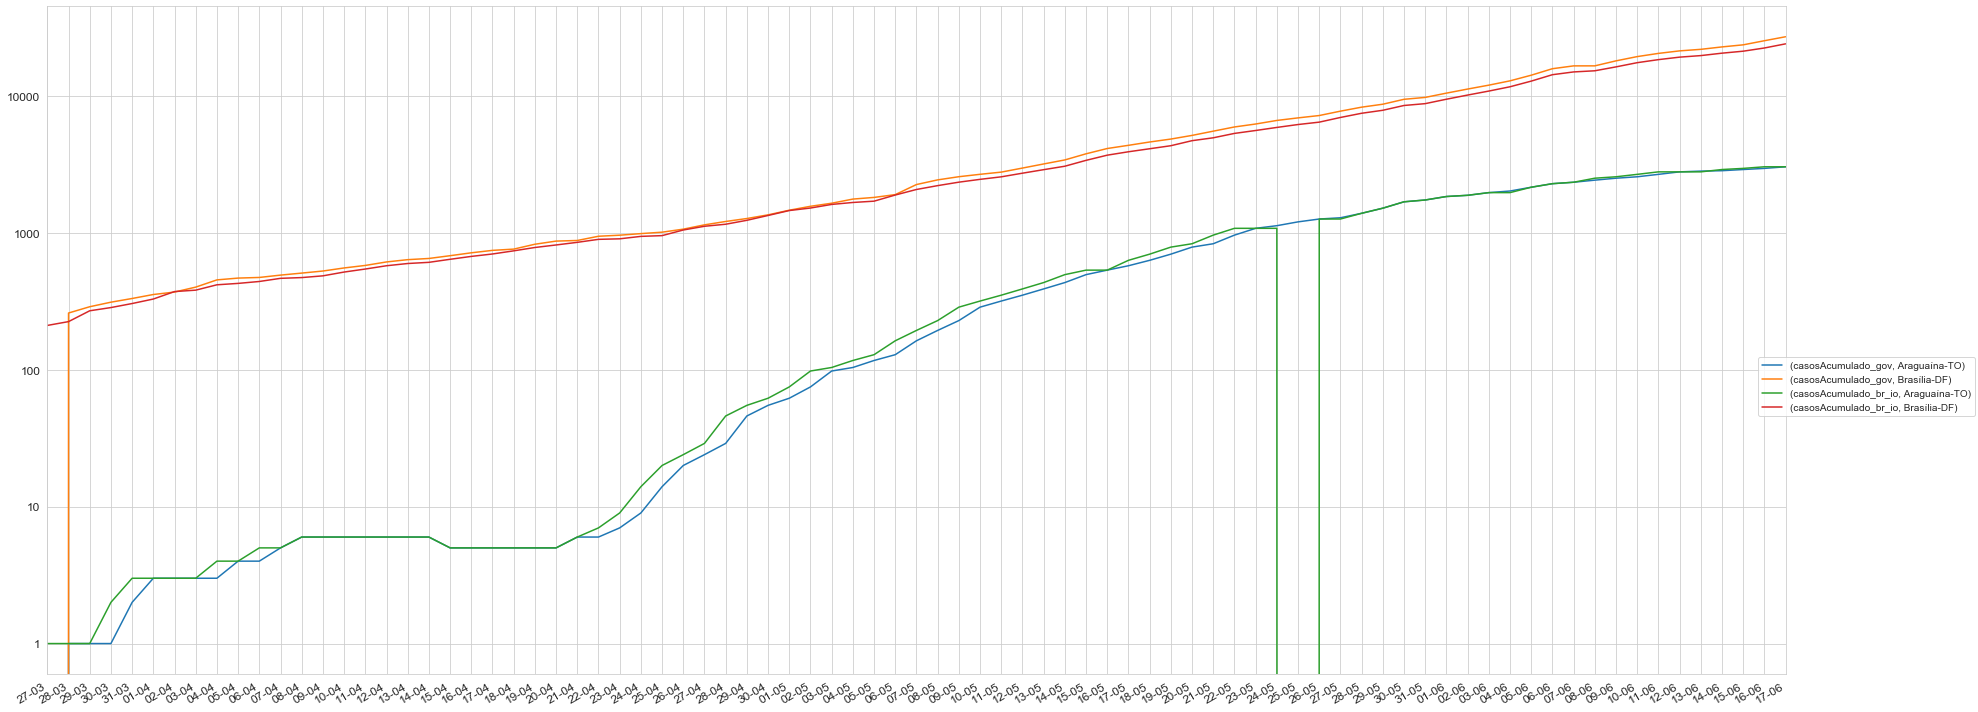

In [27]:
# comp_gov[comp_gov['municipioEstado'].isin(municipios)][['datetime', 'municipioEstado','casosAcumulado_gov', 'casosAcumulado_br_io']].head()

municipios = ['Brasília-DF', 'Araguaína-TO']
municipios2 = ['Salvador-BA', 'Recife-PE']
groupby_var = ['datetime', 'municipioEstado']
column_list = ['casosAcumulado_gov', 'casosAcumulado_br_io']
xaxis_datetime_bool = True

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

plot_data_completo(dataframe = comp_gov, column_string = 'municipioEstado', 
            rows_list = municipios, 
            groupby_list = groupby_var,
            column_list = column_list, 
            title_string = "", 
            legend_bool = True, logy_bool = True, figsize_x = 25, figsize_y = 10, 
            bbox_anchor_x = 1.1, bbox_anchor_y = 0.5, labels_fontsize = 12,
            xaxis_datetime_bool = xaxis_datetime_bool, xaxis_title_string = '', yaxis_title_string = '', axes=axes)

## Plot - Casos Acumulados (gov.br vs br.io) - Brasília após 4/15

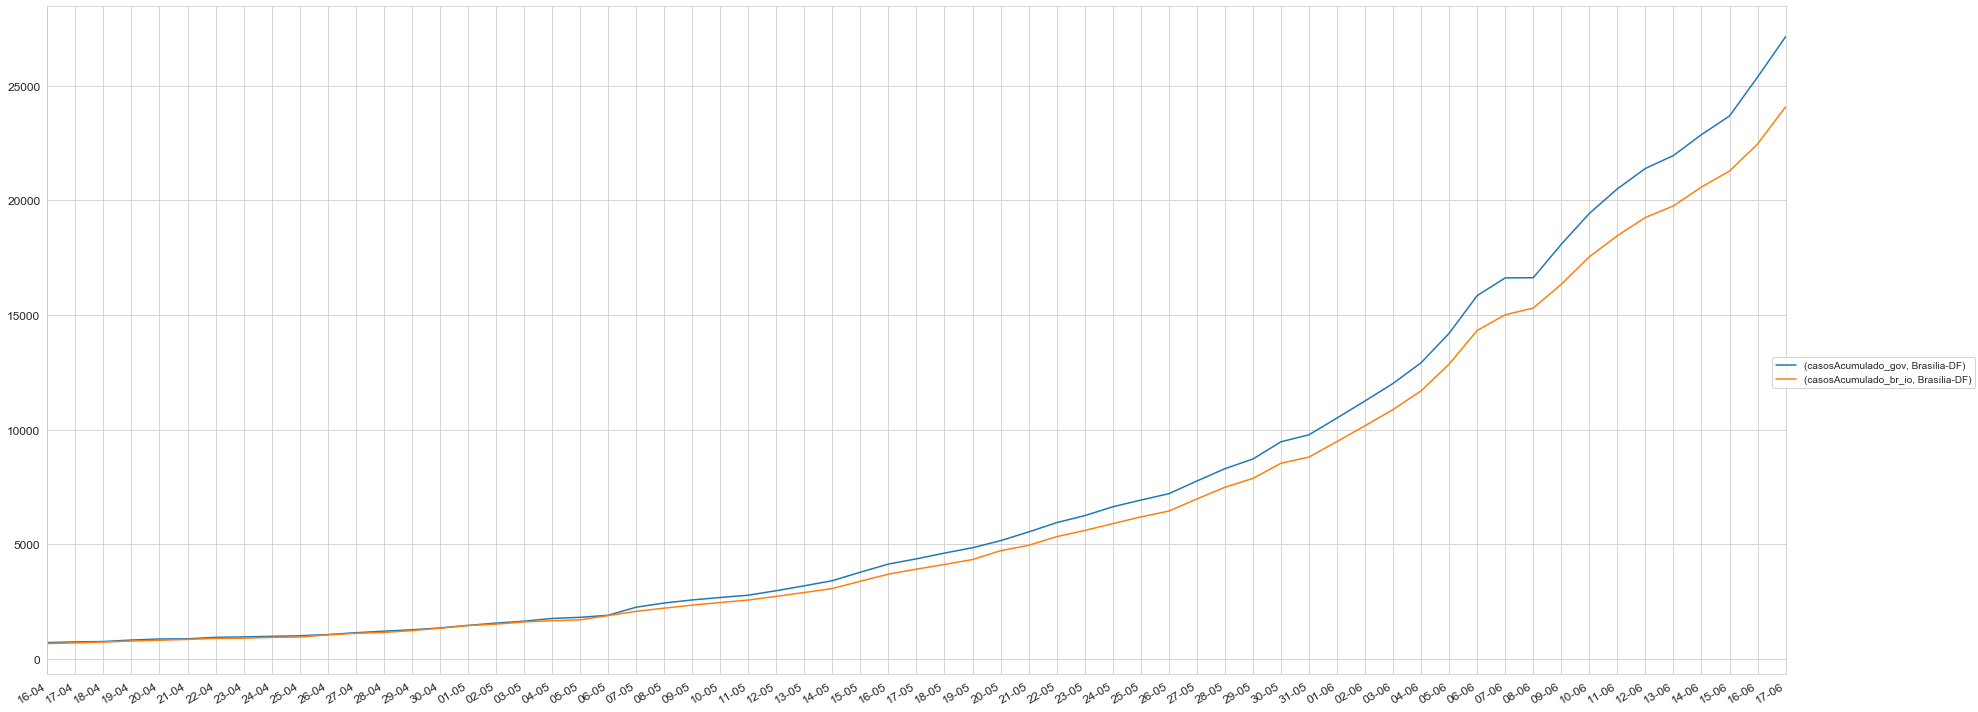

In [28]:
# comp_gov[comp_gov['municipioEstado'].isin(municipios)][['datetime', 'municipioEstado','casosAcumulado_gov', 'casosAcumulado_br_io']].head()

municipios = ['Brasília-DF']
municipios2 = ['Salvador-BA', 'Recife-PE', 'Araguaína-TO']
groupby_var = ['datetime', 'municipioEstado']
column_list = ['casosAcumulado_gov', 'casosAcumulado_br_io']
xaxis_datetime_bool = True

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

plot_data_completo(dataframe = comp_gov[(comp_gov['datetime']>'2020-04-15')], column_string = 'municipioEstado', 
            rows_list = municipios, 
            groupby_list = groupby_var,
            column_list = column_list, 
            title_string = "", 
            legend_bool = True, logy_bool = False, figsize_x = 25, figsize_y = 10, 
            bbox_anchor_x = 1.1, bbox_anchor_y = 0.5, labels_fontsize = 12,
            xaxis_datetime_bool = xaxis_datetime_bool, xaxis_title_string = '', yaxis_title_string = '', axes=axes)

## Dados gov.br

In [46]:
df_gov = dados_tratados_novos.copy()
df_gov.columns

Index(['regiao', 'estado', 'municipio', 'municipioEstado', 'tipoTerritorio',
       'datetime', 'coduf', 'codmun', 'codRegiaoSaude', 'nomeRegiaoSaude',
       'semanaEpi', 'populacaoTCU2019', 'casosAcumulado', 'obitosAcumulado',
       'casosNovos', 'obitosNovos', 'contadorDiasCasos', 'contadorObitosCasos',
       'casosNormalizado_100mil_habit', 'obitosNormalizado_100mil_habit',
       'casosNormalizado_1milhao_habit', 'obitosNormalizado_1milhao_habit',
       'Recuperadosnovos', 'emAcompanhamentoNovos'],
      dtype='object')

## Plot - Óbitos Acumulados e Acumulado Normalizados

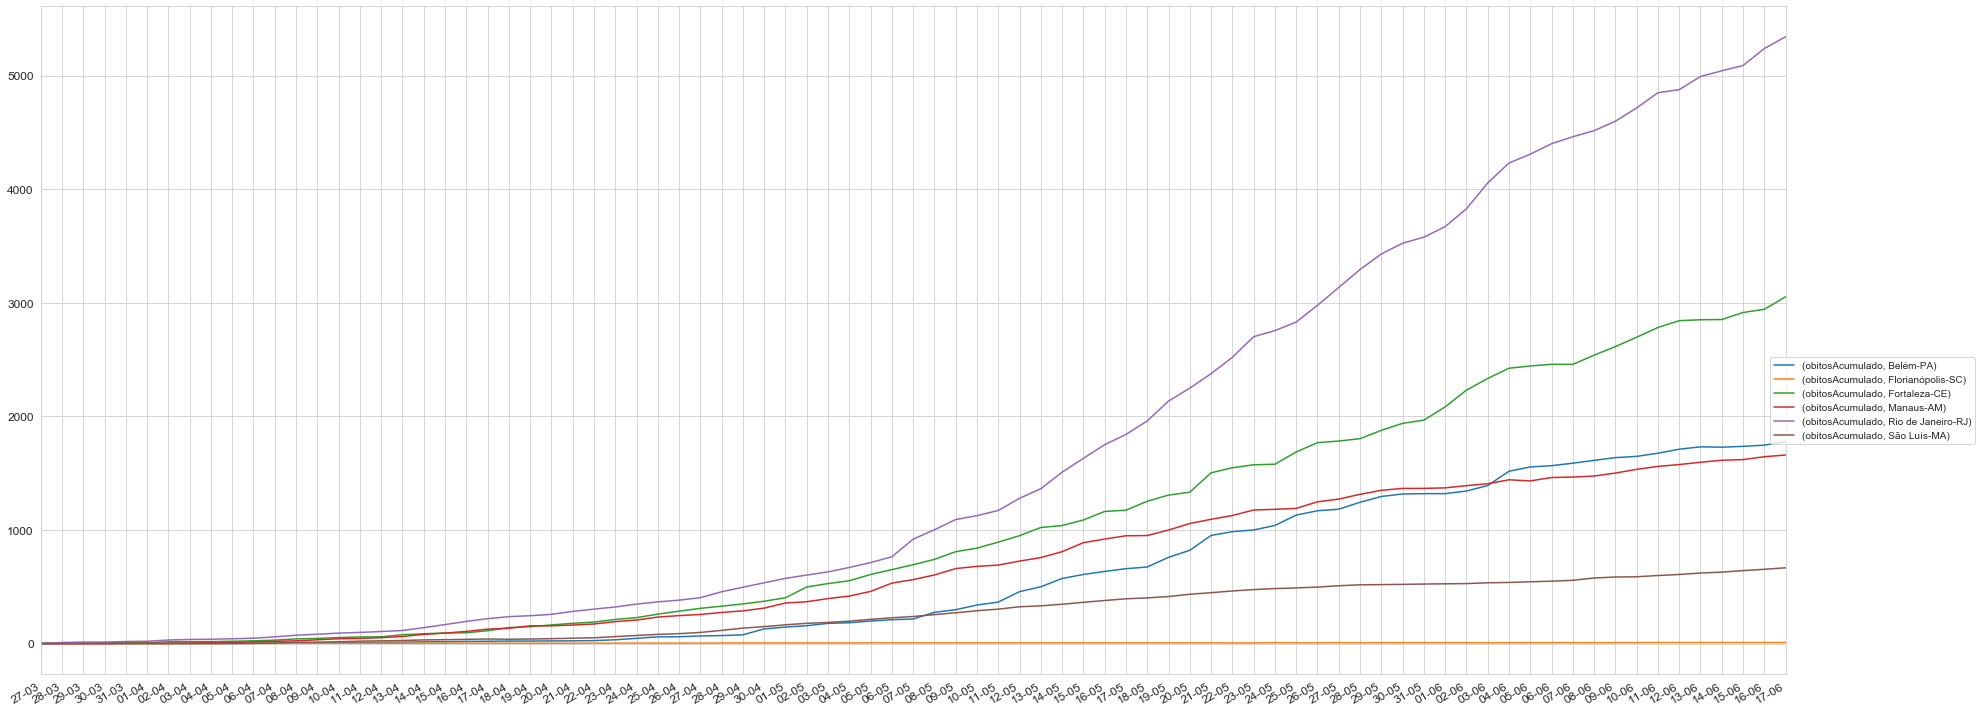

In [50]:
municipios = ['Rio de Janeiro-RJ', 'Manaus-AM', 'Florianópolis-SC', 'Belém-PA', 'Fortaleza-CE', 'São Luís-MA']
groupby_var = ['datetime', 'municipioEstado']
column_list = ['obitosAcumulado']
xaxis_datetime_bool = True

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

plot_data_completo(dataframe = df_gov, column_string = 'municipioEstado', 
            rows_list = municipios, 
            groupby_list = groupby_var,
            column_list = column_list, 
            title_string = "", 
            legend_bool = True, logy_bool = False, figsize_x = 25, figsize_y = 10, 
            bbox_anchor_x = 1.1, bbox_anchor_y = 0.5, labels_fontsize = 12,
            xaxis_datetime_bool = xaxis_datetime_bool, xaxis_title_string = '', yaxis_title_string = '', axes=axes)

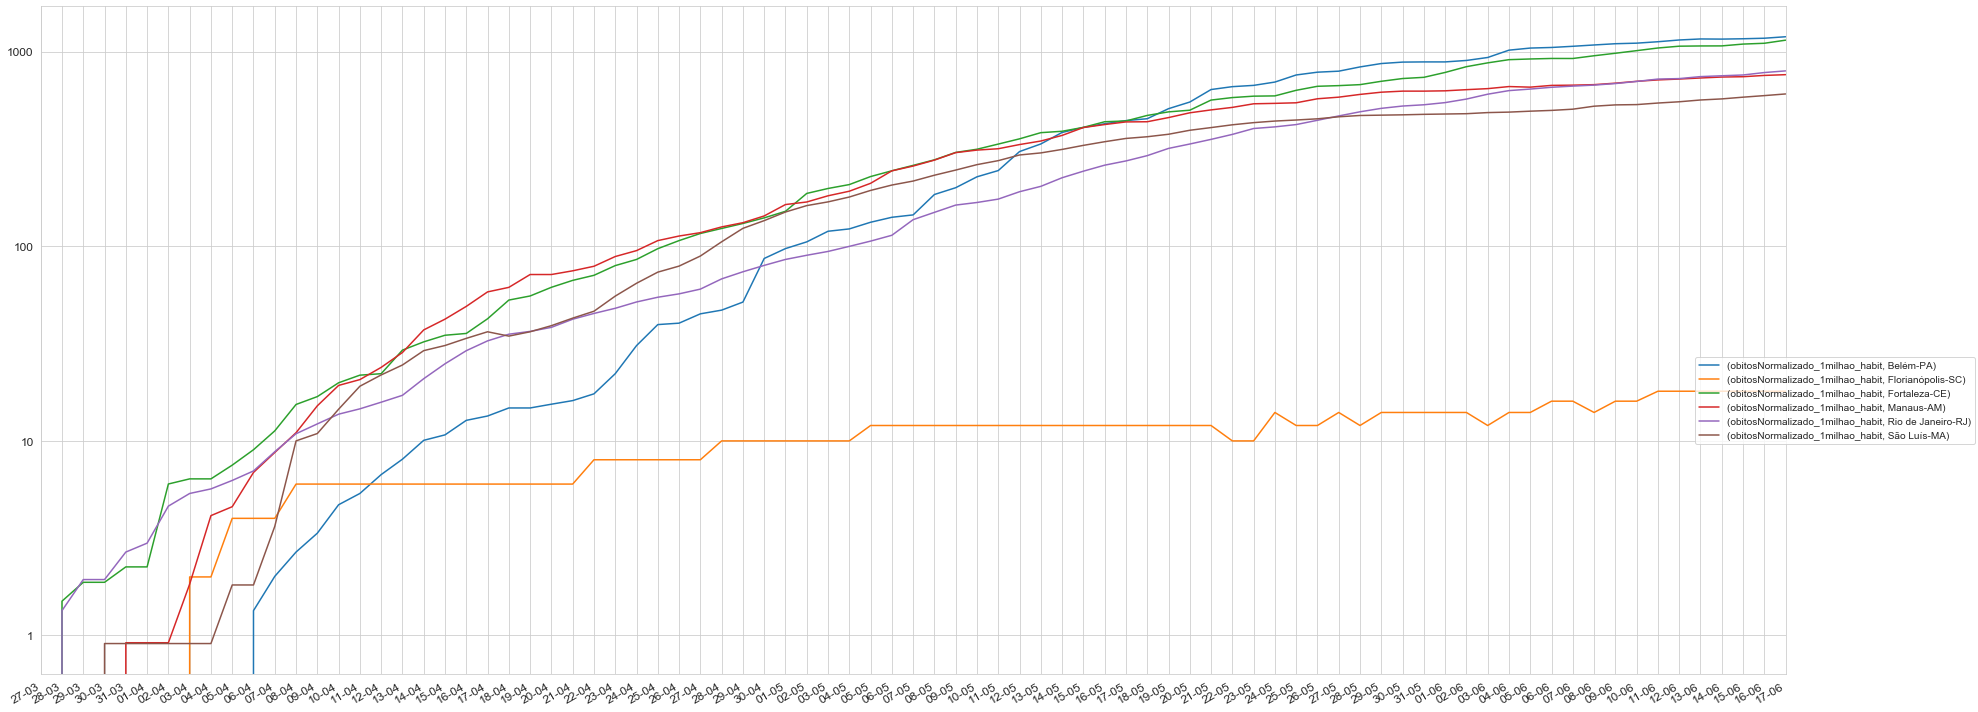

In [48]:
municipios = ['Rio de Janeiro-RJ', 'Manaus-AM', 'Florianópolis-SC', 'Belém-PA', 'Fortaleza-CE', 'São Luís-MA']
groupby_var = ['datetime', 'municipioEstado']
column_list = ['obitosNormalizado_1milhao_habit']
xaxis_datetime_bool = True

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

plot_data_completo(dataframe = df_gov, column_string = 'municipioEstado', 
            rows_list = municipios, 
            groupby_list = groupby_var,
            column_list = column_list, 
            title_string = "", 
            legend_bool = True, logy_bool = True, figsize_x = 25, figsize_y = 10, 
            bbox_anchor_x = 1.1, bbox_anchor_y = 0.5, labels_fontsize = 12,
            xaxis_datetime_bool = xaxis_datetime_bool, xaxis_title_string = '', yaxis_title_string = '', axes=axes)

## Plot Média Móvel - Óbitos Novos

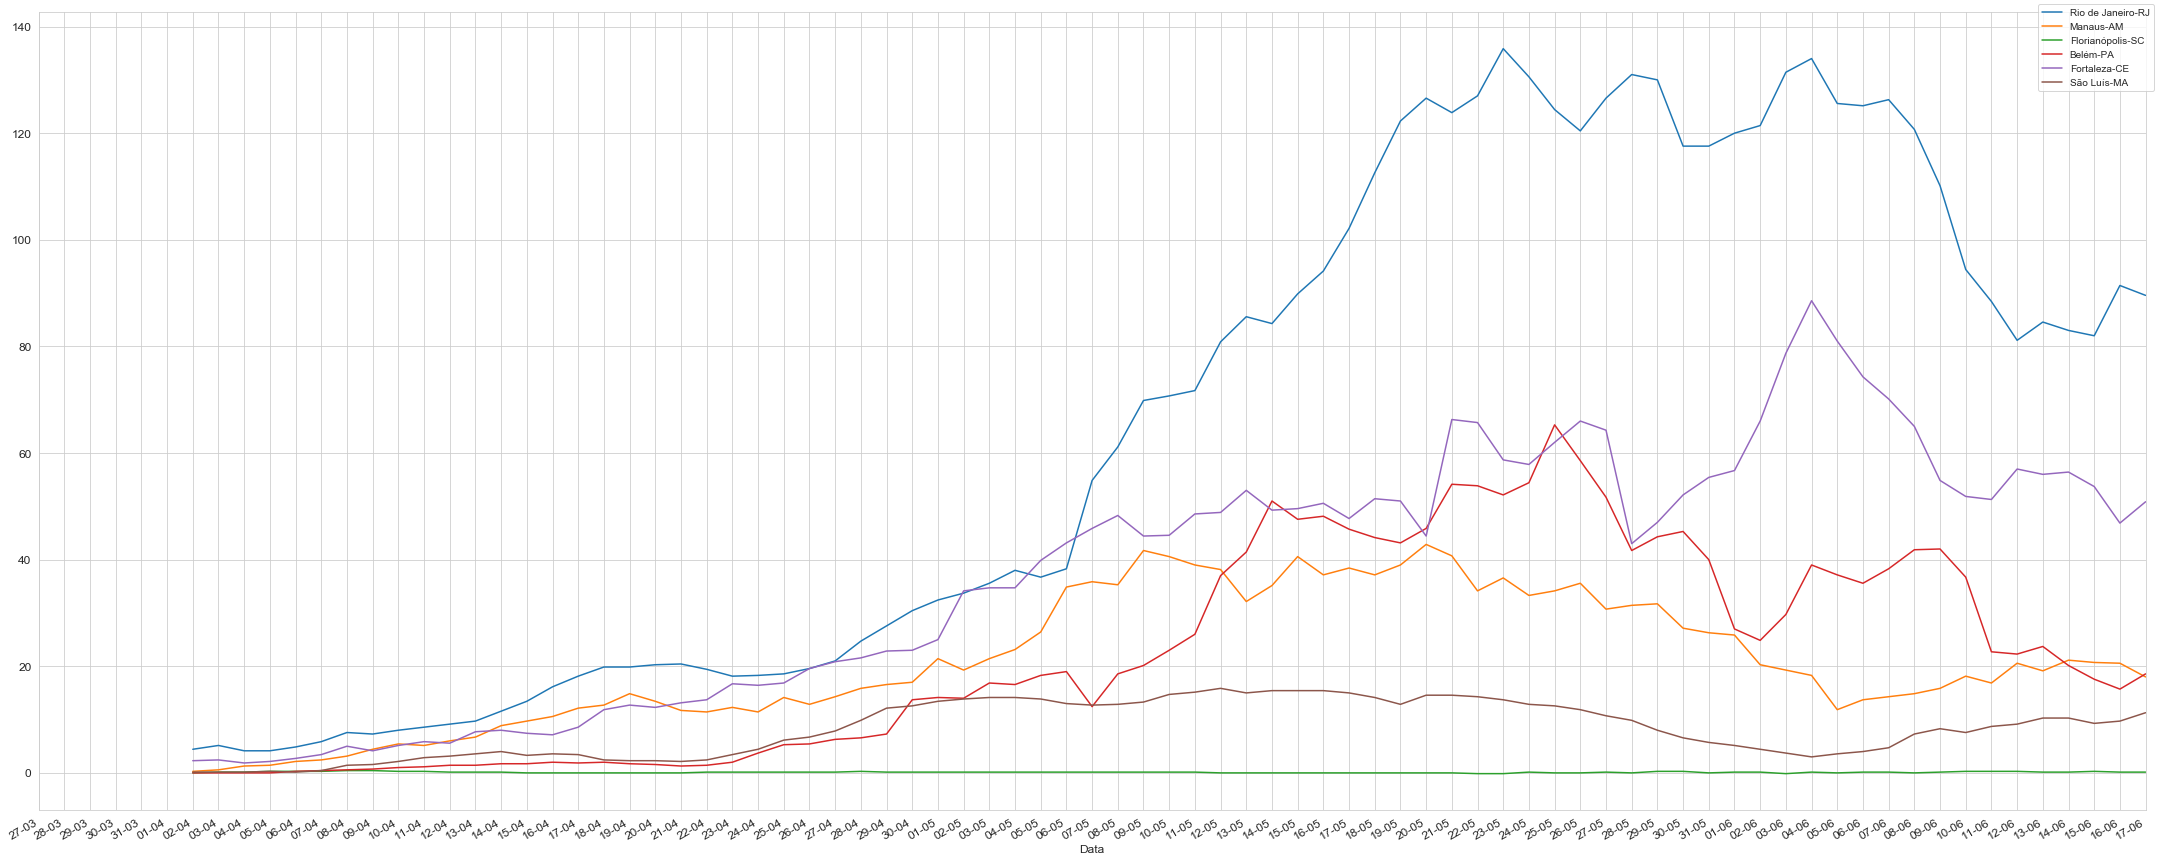

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

dataframe = df_gov
column_string = 'municipioEstado'
municipios = ['Rio de Janeiro-RJ', 'Manaus-AM', 'Florianópolis-SC', 'Belém-PA', 'Fortaleza-CE', 'São Luís-MA']
rows_list = municipios
groupby_string = 'datetime'
# groupby_var = ['datetime', 'municipioEstado']
# groupby_list=groupby_var
# column_list = ['obitosNovos_gov']
# column_list = ['municipioEstado', 'datetime','obitosNovos_gov', 'obitosNovos_br_io']
column_list = ['municipioEstado', 'datetime','obitosNovos']
rolling_type='mean'
rolling_days=7
xaxis_datetime_bool=True
(figsize_x, figsize_y, logy_bool, title_string, axes) = (30,12, False, "", axes)
legend_bool=True


for row in rows_list:
    if rolling_type == 'sum':
        dataframe[dataframe[column_string]==row][column_list].sort_values(by=groupby_string).groupby(groupby_string).sum().rolling(rolling_days).sum() \
            .plot(figsize=(figsize_x, figsize_y), legend=False, logy=logy_bool, title=title_string, ax=axes)
        
    if rolling_type == 'mean':
        dataframe[dataframe[column_string]==row][column_list].sort_values(by=groupby_string).groupby(groupby_string).mean().rolling(rolling_days).mean() \
            .plot(figsize=(figsize_x, figsize_y), legend=False, logy=logy_bool, title=title_string, ax=axes)
        
# (bbox_anchor_x, bbox_anchor_y, labels_fontsize, legend_bool,xaxis_datetime_bool, xaxis_title_string, yaxis_title_string)
caracteristicas_plot(1.0, 0.5, 12, False, xaxis_datetime_bool, "Data", "")
plt.gcf().legend(municipios)